## simple example

* generate a signal in time domain $x(t)$
* convert the singal to frequency domain $X(\omega)$
* calculated a frf $H(\omega)$
* do the DFT convolution $y(t) = fft\{x(t) * h(t)\} = X(\omega) \cdot H(\omega)$

approach 2:
* convert the frf in ir $h(t)$
* do the convolution $y(t) = x(t) * h(t) $
* calculated a ifrf $Y(\omega) = ifft\{y(t)\}$

approach 3:
 * padded

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import librosa.display
import IPython.display as ipd

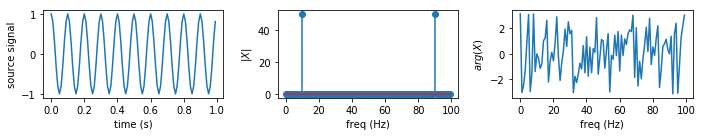

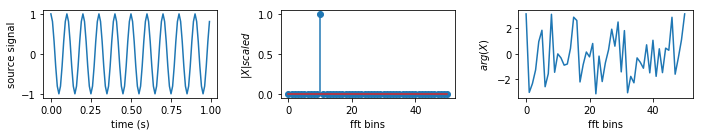

In [25]:
# this is the support in time domain -- bounded to the wave frequency
wave_frequency = 10 # p in the book, this is the signal frequency
wave_amplitude = 1
sample_period = 1/wave_frequency
sample_rate = 10/sample_period # samples per sec (rule of thumb is at least 2x the cut off frequency)
total_sampling_time = 10*sample_period # 10 points DFT
num_samples = sample_rate * total_sampling_time

t = np.arange(0, total_sampling_time, 1/sample_rate)

# signal generator
fun = lambda x: wave_amplitude * np.cos(wave_frequency * 2*np.pi * x)
signal = [fun(i) for i in t]

samples = len(signal)
frq = sample_rate * np.arange(0.1,samples) / samples
# perform the dft of signal - real signal -> complex , symmetric and conjugated response.
X = np.fft.fft(signal)
#half the sample alternative method.
Xr = np.fft.rfft(signal)

# plot
fig, (ax,ax2,ax3)= plt.subplots(1,3, figsize=(10, 2))
ax.plot(t, signal)
ax.set(xlabel='time (s)', ylabel='source signal')
# Because the power of the signal in time and frequency domain have to be equal, 
# and we just used the left half of the signal, now we need to multiply the amplitude with the factor of 2
# ax2.stem(frq, 2*np.abs(X)/sample_rate/total_sampling_time)
ax2.stem(frq, np.abs(X))
ax2.set(xlabel='freq (Hz)', ylabel='$|X|$')
ax3.plot(frq, np.angle(X))
ax3.set(xlabel='freq (Hz)', ylabel='$arg(X)$')
plt.tight_layout()

# plot alternatively
fig, (ax,ax2,ax3)= plt.subplots(1,3, figsize=(10, 2))
ax.plot(t, signal)
ax.set(xlabel='time (s)', ylabel='source signal')
ax2.stem(2*np.abs(Xr)/sample_rate/total_sampling_time)
ax2.set(xlabel='fft bins', ylabel='$|X| scaled$')
ax3.plot(np.angle(Xr))
ax3.set(xlabel='fft bins', ylabel='$arg(X)$')
plt.tight_layout()


Since **exact number of periods** is taken for DFT, all the frequency components except signal frequency = 1 Hz (and 9 Hz, which is the mirror image of signal frequency in Hz)


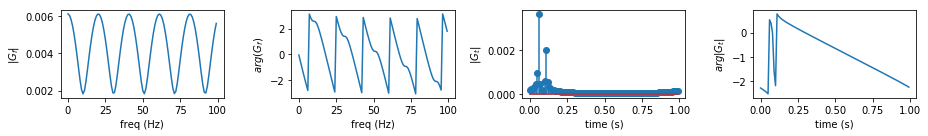

In [26]:
# sound speed
c = 344.0
# propagation distance
rd = 20
# receiver and source heights
zr = 12
zs = 20

# receiver distance from origin
xr = np.sqrt(rd**2 - (zs-zr)**2) / (1 + zs/zr)

# find the incident angle (theta) from heights and propagation distance (zs,zr,rd)
theta = np.arctan(zr/xr)
# source distance from origin
xs = zs / np.tan(theta)

# image source euclidian distance to receiver
d1 = zs / np.sin(theta) + zr/np.sin(theta)

# image source position 
xis = -xs 
zis = -zs

# porosity
phi = 0.15
# shape factor, structure factor, tortuosity
K = 6.47
# flow resistivity
sigma = 19407172
# properties of ar
# density kg.m^-3
rho = 1.2
# ratio of specific heat
gamma = 1.4
# Pradtl number
Pr = 0.71

# characteristic frequency
omega_theta = sigma / ( rho * Pr)
omega_mu = sigma*phi / ( rho * K)

# greens function
def fgreens(distance,omega):
        # propagation time direct wave
        t0 = distance / c
        g = np.exp( - 1j * omega * t0) / (4 * np.pi * distance)
        return g

# calculate the fourier transform of the reflection coefficient r(t) --- R(omega)
omega_array = 2 * np.pi * frq

# init vars
R = np.empty(samples,dtype=complex)
gf0 = np.empty(samples,dtype=complex)
gf1 = np.empty(samples,dtype=complex)

for index, omega in enumerate(omega_array):
    # porous ground properties
    G1 = np.sqrt(K * ( 1 - 1j * (omega_mu / omega)))
    G2 = np.sqrt(gamma * ( 1 - ( 1 - 1 / gamma) / (1 - 1j * omega_theta / omega)))
    # characteristic impedance of the ground
    Zgr = (rho * c / phi) * ( G1 / G2)
    
    k0 = (omega / c)
    # wavenumber of porous material
    k = k0 * G1 * G2
    #surface impedance
    Z = Zgr/(rho * c)
    
    Chi = np.sqrt(1 - ((omega / c) / k)**2 * np.cos( theta )**2 )
    
    # reflection coefficient
    R[index] =  (Z * np.sin( theta ) - Chi) / (Z * np.sin( theta ) + Chi) 
    # green function (impulse response) from direct source (ri w/ i=0,1) to receiver (r)
    gf0[index] =  fgreens(rd,omega)   
    # green function (impulse response) from image source to receiver
    gf1[index] =  fgreens(d1,omega)

Gf = gf0 +  R * gf1
# Gf is complex (but is it symetric? the plot looks like a periodic function) so Gt is also complex
Gt = np.fft.ifft(Gf)

# plot
fig, (ax,ax2,ax3,ax4)= plt.subplots(1,4, figsize=(13, 2))
ax.plot(frq, np.abs(Gf))
ax.set(xlabel='freq (Hz)', ylabel='$|G_f|$')
ax2.plot(frq, np.angle(Gf))
ax2.set(xlabel='freq (Hz)', ylabel='$arg(G_f)$')
ax3.stem(t, np.abs(Gt))
ax3.set(xlabel='time (s)', ylabel='$|G_t|$')
ax4.plot(t, np.angle(Gt))
ax4.set(xlabel='time (s)', ylabel='$arg|G_t|$')
plt.tight_layout()


perform the the linear convolution using the DFT

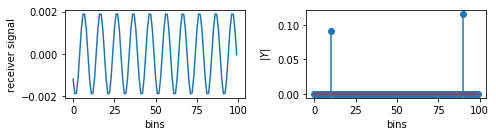

In [27]:
# X is symmetric complex conjugated
Y = X * Gf
# Y is not symmetric anymore, this receiver result in a complex signal in time
receiver = np.fft.ifft(Y)

fig, (ax,ax2)= plt.subplots(1,2, figsize=(7, 2))
ax.plot(np.real(receiver))
ax.set(xlabel='bins', ylabel='receiver signal')
ax2.stem(np.abs(Y))
ax2.set(xlabel='bins', ylabel='$|Y|$')
plt.tight_layout()

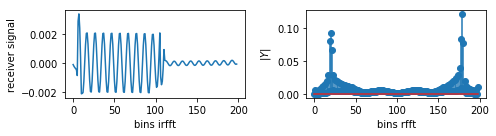

In [28]:
y = np.convolve(Gt,signal)

Y = np.fft.fft(y)

fig, (ax,ax2)= plt.subplots(1,2, figsize=(7, 2))
ax.plot(np.real(y))
ax.set(xlabel='bins irfft', ylabel='receiver signal')
ax2.stem(np.abs(Y))
ax2.set(xlabel='bins rfft', ylabel='$|Y|$')
plt.tight_layout()

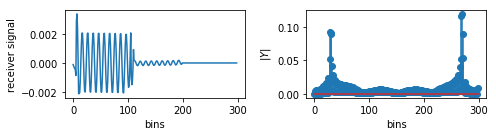

In [32]:
signalpad = np.pad(signal,(0, len(signal)+len(Gt)-1), 'constant')
Gtpad = np.pad(Gt,(0, len(signal)+len(Gt)-1), 'constant')

fftpad = np.fft.fft(signalpad) * np.fft.fft(Gtpad)
receiverpad = np.fft.ifft(fftpad)

fig, (ax,ax2)= plt.subplots(1,2, figsize=(7, 2))
ax.plot(np.real(receiverpad))
ax.set(xlabel='bins', ylabel='receiver signal')
ax2.stem(np.abs(fftpad))
ax2.set(xlabel='bins', ylabel='$|Y|$')
plt.tight_layout()